In [1]:
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from scipy.ndimage import uniform_filter1d
from torch.utils.data import DataLoader
import methods_NN as NN
import torch
from tqdm import tqdm
import pickle

# Plot setup
from pandas.plotting import register_matplotlib_converters
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
#register_matplotlib_converters()
#plt.rc("figure", figsize=(12, 8))
#plt.rc("font", size=13)

In [21]:
batch_size = 100
smoking = False

epochs = 150
learning_rate = 0.00001
hidden_layers = [500, 500, 500]
testnum = "3"

In [22]:
# Data prep
# print(data_train.__len__()) #-> 2, 2, 2, 3, 3, 3, 7, 151
# print(data_test.__len__()) #-> 2, 2, 2, 3, 7, 151
data_trn_np, data_tst_np, label_trn_np, label_tst_np = NN.load_data("full", smoking=smoking, as_numpy=True)

label_train_reshaped = np.zeros((len(label_trn_np), 2))
label_test_reshaped = np.zeros((len(label_tst_np), 2))

for i, trn in enumerate(label_trn_np):
    label_train_reshaped[i, int(trn)] = 1

for i, tst in enumerate(label_tst_np):
    label_test_reshaped[i, int(tst)] = 1

data_train = NN.NumbersDataset(data_trn_np, label_train_reshaped)
data_test = NN.NumbersDataset(data_tst_np, label_test_reshaped)

loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True, pin_memory=True)


In [23]:
# Hyperparams and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [24]:
# Model prep
model = NN.Network(
    hidden_layer_dims=hidden_layers,
    input_size=21,
    device=device
).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# Train the data
num_steps = len(loader_train)
loss_list = list()
loss_avg_trn = []
loss_avg_tst = []
for epoch in tqdm(range(epochs)):
    for i, (value, label) in enumerate(loader_train):
        sample = value.reshape(batch_size, -1).to(device)
        label = label.view(label.shape[0], 2).to(device)
        
        # forward
        output = model(sample)
        loss = criterion(output, label)
        loss_list.append(loss.item())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    with torch.no_grad():
        loss_test = []
        for value, label in loader_test:
            sample = value.to(device)
            label = label.view(label.shape[0], 2).to(device)
            
            output = model(sample)
            loss = criterion(output, label)
            
            loss_test.append(loss.item())
    
    loss_avg_trn.append(np.mean(np.array(loss_list)))
    loss_avg_tst.append(np.mean(np.array(loss_test)))
    
    loss_list = []
    loss_test = []
    

100%|██████████| 150/150 [02:14<00:00,  1.12it/s]


In [26]:
# Test the data
with torch.no_grad():
    out_list = []
    label_list = []

    labs1d = []
    pred1d = []
    n_samples = 0
    n_diff = 0
    
    for value, label in loader_test:
        sample = value.to(device)
        label = label.view(label.shape[0], 2).to(device)
        label_list += label.tolist()
        
        output = model(sample)
        out_list += output.tolist()
        _, pred = torch.max(output, 1)
        _, labs = torch.max(label, 1)
        n_diff += torch.abs(pred-labs)

        pred1d += pred.tolist()
        labs1d += labs.tolist()

        n_samples += 1
    
    #acc = n_diff/n_samples
pred1d = np.array(pred1d)
labs1d = np.array(labs1d)

In [27]:
#print(len(np.where(np.array(out_list).T[0]==0)[0]), len(np.array(out_list).T[0]))

acc = np.count_nonzero(pred1d == labs1d)/len(labs1d)
acc0 = (len(pred1d[np.where(labs1d==0)])-np.sum(pred1d[np.where(labs1d==0)]))/len(np.where(labs1d==0)[0])
acc1 = np.sum(pred1d[np.where(labs1d==1)])/len(np.where(labs1d==1)[0])

if smoking == True:
    label_name = "smoking"
else:
    label_name = "diabetes"

print(f"{acc*100:.5f}% overall accuracy")
print(f"{acc0*100:.5f}% of non {label_name} guessed correctly")
print(f"{acc1*100:.5f}% of {label_name} guessed correctly")


75.21429% overall accuracy
69.76875% of non diabetes guessed correctly
80.80486% of diabetes guessed correctly


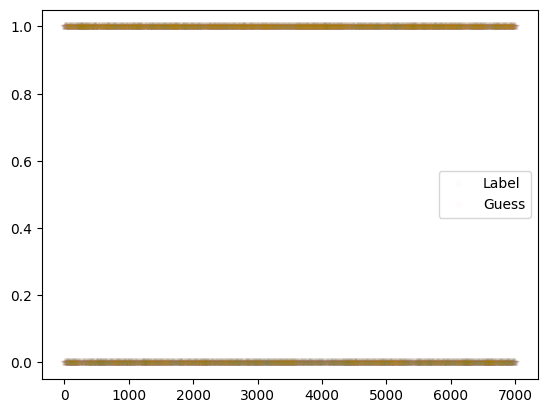

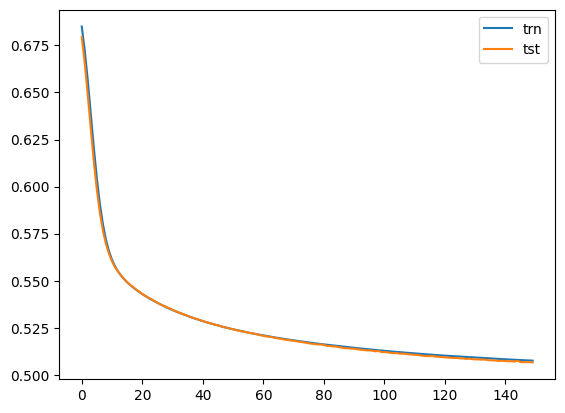

In [28]:
plt.plot(labs1d, '*', label='Label', alpha=0.01)
plt.plot(pred1d, '*', label='Guess', alpha=0.01)
plt.legend()
plt.show()

plt.plot(np.array(loss_avg_trn), label="trn")
plt.plot(np.array(loss_avg_tst), label="tst")
plt.legend()
plt.show()

In [122]:
# Save the tests
save_dict = {
    "accuracy" : acc,
    "accuracy negative" : acc0,
    "accuracy positive" : acc1,
    "Smoking" : smoking,
    "guesses" : pred1d,
    "truths" : labs1d,
    "hidden layer dims" : hidden_layers,
    "loss list" : loss_list,
    "learning rate" : learning_rate,
    "epochs" : epochs,
    "batch size" : batch_size
}

torch.save(model.state_dict(), "test"+testnum+"/model")

with open("test"+testnum+"/params.pkl", "wb") as f:
    pickle.dump(save_dict, f)

In [123]:
# Load model example
# mod = NN.Network(
#     hidden_layer_dims=[500, 125],
#     input_size=21,
#     device=device
# ).to(device)
# mod.load_state_dict(torch.load("test1/model"))